# Wine Price Prediction Using Description Embeddings vs Traditional Features

By Aidan Riordan | B.S. Statistics CofC, President Data Science Club

Dataset provided by Kyle Rees | Senior Market Research Manager @ Amazon  

## Overview
This notebook explores different approaches to predicting wine prices using machine learning. We investigated two main methods:

1. **Description Embeddings with Deep Learning**
   - Used DistilBERT to create embeddings from wine descriptions
   - Implemented neural networks with various enhancements:
     - Log price transformation
     - Residual connections
     - Attention mechanisms
     - Custom price-aware loss function
   - Results:
     - R² Score: 0.308
     - Mean Absolute Error: \$78.28
     - Root Mean Squared Error: \$126.64

2. **Traditional Features with XGBoost (Previous Notebook)**
   - Used features like Producer, Variety, Region, etc.
   - Applied XGBoost with hyperparameter optimization
   - Results:
     - R² Score: 0.691 (±0.017)
     - Mean Absolute Error: \$38.14 (±2.45)
     - Mean Squared Error: 4,678.58 (±626.82)

## Key Findings
- XGBoost with traditional features outperformed the deep learning approach
- Description embeddings showed promise in capturing wine characteristics
- Price predictions were most accurate in the 50-200 dollar range for both approaches
- Both models struggled with very low (< 50 dollars) and very high (>500 dollars) prices

## Future Steps
1. **Data Requirements**
   - Current dataset size limits the effectiveness of deep learning approaches
   - Larger dataset would better leverage attention mechanisms and deep architectures

2. **Research Integration**
   Following the work of Li et al. (2024) "Tree-Regularized Tabular Embeddings", we could explore:

   a) **Tree-Guided Text Embeddings**:
      - Train XGBoost models on wine description text features
      - Use tree structure to guide the transformation of text embeddings
      - Create homogeneous representations that capture both price sensitivity and description semantics

   b) **Hybrid Architecture**:
      - Implement their T2T approach for traditional features (region, producer, etc.)
      - Combine with a parallel BERT pathway for descriptions
      - Use attention mechanisms to learn interactions between both feature types
      - Could potentially solve the price range bias we observed

   c) **Price-Aware Loss Functions**:
      - Adapt their price-aware loss function for wine pricing context
      - Add weights based on price ranges to better handle extreme values
      - Could help with the poor performance in <50 and >500 ranges

   d) **Scalable Implementation**:
      - Use their "in-batch transformation" technique for efficient processing
      - Apply matrix manipulation for faster embedding generation
      - Would allow us to handle larger wine datasets and more complex descriptions

3. **Hybrid Model Evaluation**:
   - Compare performance of combined approach against our current results
   - Evaluate if tree regularization helps with price range prediction
   - Test robustness across different wine types and price points

The experiments demonstrate the complementary strengths of both approaches: embeddings capture nuanced description information while traditional features provide strong predictive power. Future work should focus on combining these approaches while expanding the dataset to better leverage deep learning capabilities.


Import Data

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
#pytorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np


# Load the data
df = pd.read_excel("amazon_wine.xlsx")
print("Initial shape:", df.shape)
print("\nFirst few rows:")
df.head()



C:\Users\aidan\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Initial shape: (3314, 16)

First few rows:


,Producer,Product,Link,Price,Stock Availability,Bottle Size,Ratings,Reviewers,Description,Vintage,Variety,Region,Color/Type,Country,Appellation,SubRegion
0,Salon,2013 Salon - Champagne Brut Blanc de Blancs Le...,https://bassins.com/2013-salon-brut-blanc-de-b...,2900.0,1,1.5L,99,VM,"The 2013 is the most powerful, dense young Sal...",2013,Champagne,Champagne,Sparkling,France,Champagne,NaN
1,Georges Roumier,1999 Georges Roumier Bonnes Mares,https://bassins.com/1999-georges-roumier-bonne...,2700.0,3,750ml,97,VM,"Good deep red. Aromas of black raspberry, grap...",1999,Pinot Noir/Pinot Nero,Burgundy,Red,France,Bonnes Mares,NaN
2,Henri Boillot,2020 Henri Boillot Montrachet,https://bassins.com/2020-henri-boillot-montrac...,2499.0,1,750ml,96-99,JM,1 x 350 litre barrel. Not especially deep in c...,2020,Chardonnay,Burgundy,White,France,Montrachet,NaN
3,Giacosa,2016 Giacosa - Barbaresco Riserva Asili DOUBLE...,https://bassins.com/2016-giacosa-barbaresco-ri...,2400.0,1,3L,97+,WA,"Packaged in its distinctive red label, the 201...",2016,Nebbiolo,Piemonte,Red,Italy,Barbaresco DOCG,NaN
4,Krug,2008 Krug - Brut Clos du Mesnil,https://bassins.com/2008-krug-brut-clos-du-mesnil,2100.0,2,750ml,99,VM,"Krug’s 2008 Clos du Mesnil, tasted from two bo...",2008,Champagne,Champagne,Sparkling,France,Brut,NaN


 initial data preprocessing:

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from transformers import DistilBertTokenizer, DistilBertModel
import matplotlib.pyplot as plt

# Load the data
df = pd.read_excel("amazon_wine.xlsx")

# Keep only description and price columns
df = df[['Description', 'Price']].copy()

# Remove rows with missing descriptions
df = df.dropna(subset=['Description'])

# Remove price outliers using IQR
Q1 = df['Price'].quantile(0.1)
Q3 = df['Price'].quantile(0.9)
IQR = Q3 - Q1
df = df[
    (df['Price'] >= Q1 - 1.5 * IQR) &
    (df['Price'] <= Q3 + 1.5 * IQR)
]

print("Shape after preprocessing:", df.shape)
print("\nSample description:")
print(df['Description'].iloc[0])

Shape after preprocessing: (1886, 2)

Sample description:
One of the greatest wines produced in Bordeaux this year is the 2019 Lafite Rothschild, an impeccably balanced classic of immense charm and grace. Wafting from the glass with arresting aromas of cassis, blackberries and cherries mingled with violets, ciga...


## embedding generation

In [3]:
def generate_embeddings(texts, batch_size=16):
    # Convert texts to list if it's a pandas Series
    if hasattr(texts, 'tolist'):
        texts = texts.tolist()
    
    # Initialize tokenizer and model
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    model = DistilBertModel.from_pretrained('distilbert-base-uncased')
    model.eval()
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    all_embeddings = []
    
    # Process texts in batches
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        
        try:
            # Ensure all texts in batch are strings
            batch_texts = [str(text) for text in batch_texts]
            
            # Tokenize texts
            encoded = tokenizer(
                batch_texts,
                padding=True,
                truncation=True,
                max_length=512,
                return_tensors='pt'
            )
            
            # Move inputs to same device as model
            input_ids = encoded['input_ids'].to(device)
            attention_mask = encoded['attention_mask'].to(device)
            
            # Generate embeddings
            with torch.no_grad():
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
                all_embeddings.append(embeddings)
            
            if (i + batch_size) % 100 == 0:
                print(f"Processed {i + batch_size}/{len(texts)} texts")
                
        except Exception as e:
            print(f"Error processing batch {i} to {i + batch_size}: {str(e)}")
            print(f"Problem text sample: {batch_texts[0][:100]}...")
            raise
    
    final_embeddings = np.vstack(all_embeddings)
    print(f"\nFinal embeddings shape: {final_embeddings.shape}")
    
    return final_embeddings

print("Starting embedding generation...")
print(f"Total descriptions to process: {len(df['Description'])}")
print(f"Sample description: {df['Description'].iloc[0][:100]}...")

embeddings = generate_embeddings(df['Description'])
print("Embedding generation completed!")

Starting embedding generation...
Total descriptions to process: 1886
Sample description: One of the greatest wines produced in Bordeaux this year is the 2019 Lafite Rothschild, an impeccabl...


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Processed 400/1886 texts
Processed 800/1886 texts
Processed 1200/1886 texts
Processed 1600/1886 texts

Final embeddings shape: (1886, 768)
Embedding generation completed!


##  neural network model

In [4]:
class WineDataset(torch.utils.data.Dataset):
    def __init__(self, embeddings, prices):
        self.embeddings = torch.FloatTensor(embeddings)
        self.prices = torch.FloatTensor(prices)
    
    def __len__(self):
        return len(self.prices)
    
    def __getitem__(self, idx):
        return self.embeddings[idx], self.prices[idx]

class WinePricePredictor(nn.Module):
    def __init__(self, embedding_dim):
        super(WinePricePredictor, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(embedding_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    
    def forward(self, x):
        return self.model(x)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    embeddings, df['Price'].values, 
    test_size=0.2, random_state=42
)

# Create datasets and dataloaders
train_dataset = WineDataset(X_train, y_train)
test_dataset = WineDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = WinePricePredictor(embeddings.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50
train_losses = []
val_losses = []

print(f"Training on {device}")
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch_embeddings, batch_prices in train_loader:
        batch_embeddings = batch_embeddings.to(device)
        batch_prices = batch_prices.to(device).reshape(-1, 1)
        
        optimizer.zero_grad()
        outputs = model(batch_embeddings)
        loss = criterion(outputs, batch_prices)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_embeddings, batch_prices in test_loader:
            batch_embeddings = batch_embeddings.to(device)
            batch_prices = batch_prices.to(device).reshape(-1, 1)
            outputs = model(batch_embeddings)
            val_loss += criterion(outputs, batch_prices).item()
    
    train_losses.append(epoch_loss / len(train_loader))
    val_losses.append(val_loss / len(test_loader))
    
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

print("Training completed!")

Training on cpu
Epoch [5/50], Train Loss: 24768.8170, Val Loss: 22266.2950
Epoch [10/50], Train Loss: 22679.1738, Val Loss: 19034.0365
Epoch [15/50], Train Loss: 21223.2238, Val Loss: 19379.5236
Epoch [20/50], Train Loss: 21076.4315, Val Loss: 18793.8396
Epoch [25/50], Train Loss: 18976.3056, Val Loss: 20114.3514
Epoch [30/50], Train Loss: 16845.1282, Val Loss: 19047.0470
Epoch [35/50], Train Loss: 16550.2807, Val Loss: 19541.6026
Epoch [40/50], Train Loss: 15200.8015, Val Loss: 19493.9338
Epoch [45/50], Train Loss: 14446.1083, Val Loss: 19753.7574
Epoch [50/50], Train Loss: 12420.6780, Val Loss: 19475.0070
Training completed!


## Model Evaluation

Model Performance Metrics:
R² Score: 0.155
Mean Absolute Error: $90.62
Root Mean Squared Error: $139.90


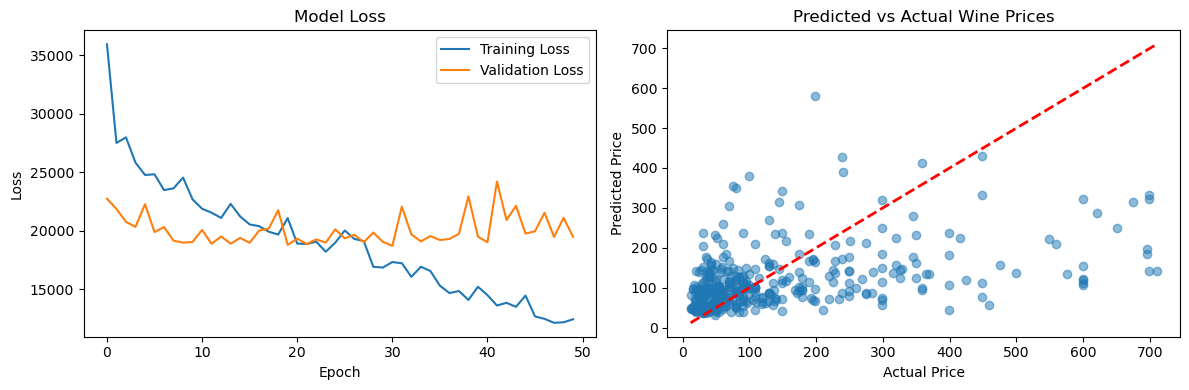


Price Prediction Range: ±$137.92

Example Predictions:
Actual: $269.00, Predicted: $122.29, Difference: $146.71
Actual: $225.00, Predicted: $143.32, Difference: $81.68
Actual: $179.00, Predicted: $93.42, Difference: $85.58
Actual: $24.99, Predicted: $88.53, Difference: $63.54
Actual: $79.99, Predicted: $350.72, Difference: $270.73


In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Get predictions for test set
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for batch_features, batch_prices in test_loader:
        batch_features = batch_features.to(device)
        outputs = model(batch_features).cpu().numpy()
        y_pred.extend(outputs)
        y_true.extend(batch_prices.numpy())

y_pred = np.array(y_pred).reshape(-1)
y_true = np.array(y_true)

# Calculate metrics
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

print("Model Performance Metrics:")
print(f"R² Score: {r2:.3f}")
print(f"Mean Absolute Error: ${mae:.2f}")
print(f"Root Mean Squared Error: ${rmse:.2f}")

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Predicted vs Actual Wine Prices')

plt.tight_layout()
plt.show()

# Calculate price prediction range
std_price = np.std(y_true - y_pred)
print(f"\nPrice Prediction Range: ±${std_price:.2f}")

# Show a few example predictions
print("\nExample Predictions:")
for i in range(5):
    print(f"Actual: ${y_true[i]:.2f}, Predicted: ${y_pred[i]:.2f}, "
          f"Difference: ${abs(y_true[i] - y_pred[i]):.2f}")

## Poor results, lets try Log price

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from transformers import DistilBertTokenizer, DistilBertModel
import matplotlib.pyplot as plt

# Load the data
df = pd.read_excel("amazon_wine.xlsx")

# Keep only description and price columns
df = df[['Description', 'Price']].copy()

# Remove rows with missing descriptions
df = df.dropna(subset=['Description'])

# Remove price outliers using IQR
Q1 = df['Price'].quantile(0.1)
Q3 = df['Price'].quantile(0.9)
IQR = Q3 - Q1
df = df[
    (df['Price'] >= Q1 - 1.5 * IQR) &
    (df['Price'] <= Q3 + 1.5 * IQR)
]

# Create log-transformed price column
df['Price_Log'] = np.log1p(df['Price'])  # log1p to handle zero values if any

# Plot price distributions before and after transformation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.hist(df['Price'], bins=50)
ax1.set_title('Original Price Distribution')
ax1.set_xlabel('Price')
ax1.set_ylabel('Frequency')

ax2.hist(df['Price_Log'], bins=50)
ax2.set_title('Log-Transformed Price Distribution')
ax2.set_xlabel('Log Price')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print("Shape after preprocessing:", df.shape)
print("\nPrice statistics:")
print(f"Original - Mean: ${df['Price'].mean():.2f}, Std: ${df['Price'].std():.2f}")
print(f"Log-transformed - Mean: {df['Price_Log'].mean():.2f}, Std: {df['Price_Log'].std():.2f}")

In [9]:
# Step 8: Save the DataFrame to an Excel file and download it
amazon_wine_price.to_excel('amazon_wine_price.xlsx', index=False)

# Step 9: Use files.download to download the file
#from google.colab import files
#files.download('amazon_wine_price.xlsx')


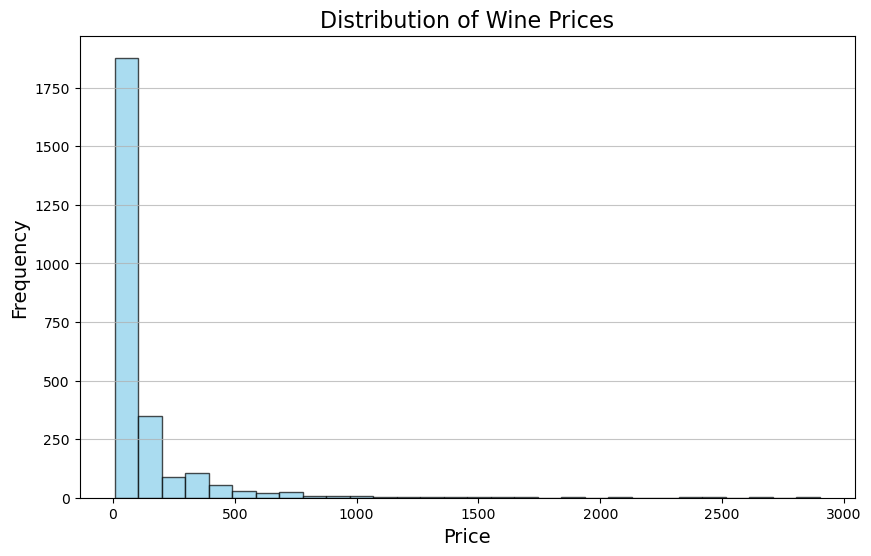

In [15]:
import matplotlib.pyplot as plt

# Plot the distribution of prices
plt.figure(figsize=(10, 6))
plt.hist(amazon_wine_price_2['Price'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Wine Prices', fontsize=16)
plt.xlabel('Price', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', alpha=0.75)
plt.show()


In [21]:
# Calculate the standard deviation of the 'Price' column
price_std = amazon_wine_price_2_encoded['Price'].std()

# Output the standard deviation
print(f"Standard Deviation of Price: {price_std:.2f}")


Standard Deviation of Price: 123.47


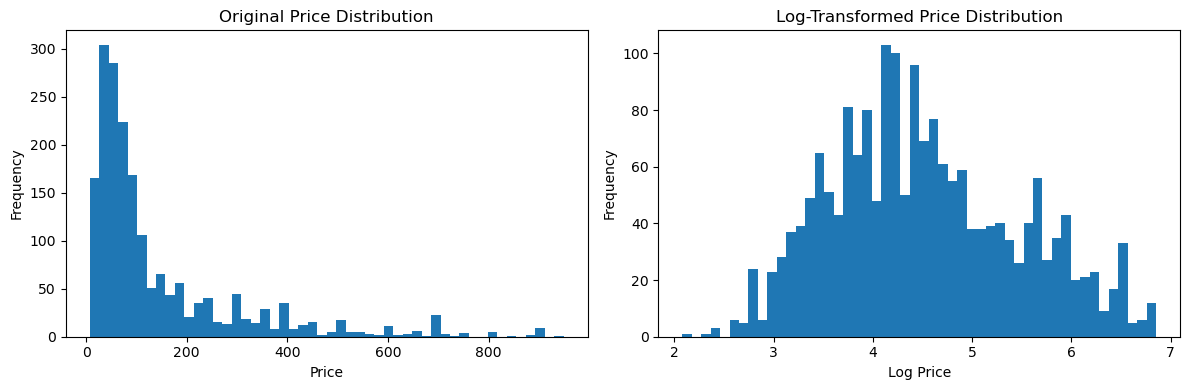

Shape after preprocessing: (1886, 3)

Price statistics:
Original - Mean: $145.44, Std: $163.67
Log-transformed - Mean: 4.51, Std: 0.95


In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from transformers import DistilBertTokenizer, DistilBertModel
import matplotlib.pyplot as plt

# Load the data
df = pd.read_excel("amazon_wine.xlsx")

# Keep only description and price columns
df = df[['Description', 'Price']].copy()

# Remove rows with missing descriptions
df = df.dropna(subset=['Description'])

# Remove price outliers using IQR
Q1 = df['Price'].quantile(0.1)
Q3 = df['Price'].quantile(0.9)
IQR = Q3 - Q1
df = df[
    (df['Price'] >= Q1 - 1.5 * IQR) &
    (df['Price'] <= Q3 + 1.5 * IQR)
]

# Create log-transformed price column
df['Price_Log'] = np.log1p(df['Price'])  # log1p to handle zero values if any

# Plot price distributions before and after transformation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.hist(df['Price'], bins=50)
ax1.set_title('Original Price Distribution')
ax1.set_xlabel('Price')
ax1.set_ylabel('Frequency')

ax2.hist(df['Price_Log'], bins=50)
ax2.set_title('Log-Transformed Price Distribution')
ax2.set_xlabel('Log Price')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print("Shape after preprocessing:", df.shape)
print("\nPrice statistics:")
print(f"Original - Mean: ${df['Price'].mean():.2f}, Std: ${df['Price'].std():.2f}")
print(f"Log-transformed - Mean: {df['Price_Log'].mean():.2f}, Std: {df['Price_Log'].std():.2f}")

In [16]:
class WineDataset(torch.utils.data.Dataset):
    def __init__(self, embeddings, prices):
        self.embeddings = torch.FloatTensor(embeddings)
        self.prices = torch.FloatTensor(prices)
    
    def __len__(self):
        return len(self.prices)
    
    def __getitem__(self, idx):
        return self.embeddings[idx], self.prices[idx]

class WinePricePredictor(nn.Module):
    def __init__(self, embedding_dim):
        super(WinePricePredictor, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(embedding_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    
    def forward(self, x):
        return self.model(x)

# Split the data using log-transformed prices
X_train, X_test, y_train, y_test = train_test_split(
    embeddings, df['Price_Log'].values, 
    test_size=0.2, random_state=42
)

# Save original prices for later evaluation
_, _, y_train_orig, y_test_orig = train_test_split(
    embeddings, df['Price'].values, 
    test_size=0.2, random_state=42
)

# Create datasets and dataloaders
train_dataset = WineDataset(X_train, y_train)
test_dataset = WineDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = WinePricePredictor(embeddings.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50
train_losses = []
val_losses = []

print(f"Training on {device}")
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch_embeddings, batch_prices in train_loader:
        batch_embeddings = batch_embeddings.to(device)
        batch_prices = batch_prices.to(device).reshape(-1, 1)
        
        optimizer.zero_grad()
        outputs = model(batch_embeddings)
        loss = criterion(outputs, batch_prices)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_embeddings, batch_prices in test_loader:
            batch_embeddings = batch_embeddings.to(device)
            batch_prices = batch_prices.to(device).reshape(-1, 1)
            outputs = model(batch_embeddings)
            val_loss += criterion(outputs, batch_prices).item()
    
    train_losses.append(epoch_loss / len(train_loader))
    val_losses.append(val_loss / len(test_loader))
    
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

print("Training completed!")

Training on cpu
Epoch [5/50], Train Loss: 0.9644, Val Loss: 0.6991
Epoch [10/50], Train Loss: 0.8220, Val Loss: 0.7891
Epoch [15/50], Train Loss: 0.7625, Val Loss: 0.6516
Epoch [20/50], Train Loss: 0.7250, Val Loss: 0.7488
Epoch [25/50], Train Loss: 0.7884, Val Loss: 0.7092
Epoch [30/50], Train Loss: 0.6915, Val Loss: 0.6567
Epoch [35/50], Train Loss: 0.6686, Val Loss: 0.8063
Epoch [40/50], Train Loss: 0.6399, Val Loss: 0.6988
Epoch [45/50], Train Loss: 0.6012, Val Loss: 0.8008
Epoch [50/50], Train Loss: 0.6324, Val Loss: 0.6349
Training completed!


Model Performance Metrics:
R² Score: 0.157
Mean Absolute Error: $85.22
Root Mean Squared Error: $139.76


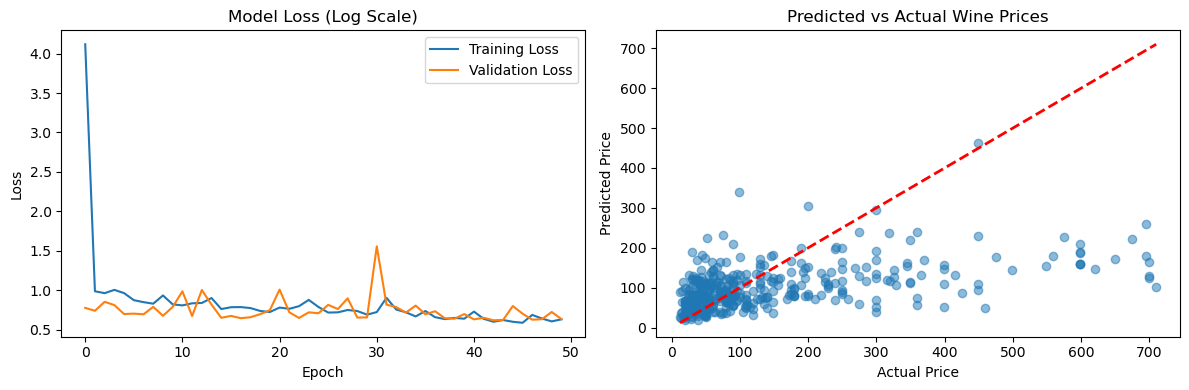


Median Relative Error: 54.3%

Example Predictions:
Actual: $269.00, Predicted: $150.48, Difference: $118.52, Relative Error: 44.1%
Actual: $225.00, Predicted: $113.68, Difference: $111.32, Relative Error: 49.5%
Actual: $179.00, Predicted: $80.27, Difference: $98.73, Relative Error: 55.2%
Actual: $24.99, Predicted: $80.66, Difference: $55.67, Relative Error: 222.8%
Actual: $79.99, Predicted: $163.25, Difference: $83.26, Relative Error: 104.1%

Prediction Accuracy by Price Range:
$0-$50: MAE=$39.80, Median Relative Error=106.8%
$50-$100: MAE=$35.77, Median Relative Error=32.8%
$100-$200: MAE=$54.46, Median Relative Error=38.0%
$200-$500: MAE=$180.17, Median Relative Error=59.1%
$500-$inf: MAE=$460.76, Median Relative Error=73.4%


In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Get predictions
model.eval()
y_pred_log = []
y_true_log = []

with torch.no_grad():
    for batch_embeddings, batch_prices in test_loader:
        batch_embeddings = batch_embeddings.to(device)
        outputs = model(batch_embeddings).cpu().numpy()
        y_pred_log.extend(outputs)
        y_true_log.extend(batch_prices.numpy())

y_pred_log = np.array(y_pred_log).reshape(-1)
y_true_log = np.array(y_true_log)

# Convert predictions back to original scale
y_pred = np.expm1(y_pred_log)  # inverse of log1p
y_true = y_test_orig  # using original prices saved earlier

# Calculate metrics
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

print("Model Performance Metrics:")
print(f"R² Score: {r2:.3f}")
print(f"Mean Absolute Error: ${mae:.2f}")
print(f"Root Mean Squared Error: ${rmse:.2f}")

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss (Log Scale)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Predicted vs Actual Wine Prices')

plt.tight_layout()
plt.show()

# Calculate relative error
relative_error = np.abs(y_true - y_pred) / y_true * 100
print(f"\nMedian Relative Error: {np.median(relative_error):.1f}%")

# Show a few example predictions
print("\nExample Predictions:")
for i in range(5):
    print(f"Actual: ${y_true[i]:.2f}, Predicted: ${y_pred[i]:.2f}, "
          f"Difference: ${abs(y_true[i] - y_pred[i]):.2f}, "
          f"Relative Error: {relative_error[i]:.1f}%")

# Additional analysis of prediction accuracy by price range
price_ranges = [0, 50, 100, 200, 500, float('inf')]
print("\nPrediction Accuracy by Price Range:")
for i in range(len(price_ranges)-1):
    mask = (y_true >= price_ranges[i]) & (y_true < price_ranges[i+1])
    if sum(mask) > 0:
        range_mae = mean_absolute_error(y_true[mask], y_pred[mask])
        range_relative_error = np.median(relative_error[mask])
        print(f"${price_ranges[i]}-${price_ranges[i+1]}: "
              f"MAE=${range_mae:.2f}, Median Relative Error={range_relative_error:.1f}%")

## Try to improve the NN

Looking at the scatter plot, the model is  biased towards predicting prices in the $50-$200 range. Let's improve the neural network architecture to better handle the full price range. 


## 1) Residual Connections: Added residual blocks to help the model learn hierarchical features and prevent vanishing gradients
## 2) Attention Mechanism: Added a price range attention mechanism to help the model focus on relevant features for different price ranges
## 3) Batch Normalization: Added throughout the network to stabilize training and allow higher learning rates
## 4) Custom Loss Function: Created a price-aware loss function that penalizes errors more heavily for higher-priced wines
## 5) Advanced Optimizer: Using AdamW with weight decay and OneCycleLR scheduler for better convergence
## 6) Gradient Clipping: Added to prevent exploding gradients

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Linear(in_features, in_features),
            nn.BatchNorm1d(in_features),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features, in_features),
            nn.BatchNorm1d(in_features)
        )
        
    def forward(self, x):
        return F.relu(x + self.block(x))

class PriceRangeAttention(nn.Module):
    def __init__(self, in_features):
        super(PriceRangeAttention, self).__init__()
        self.attention = nn.Sequential(
            nn.Linear(in_features, 64),
            nn.Tanh(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        weights = self.attention(x)
        return x * weights

class ImprovedWinePricePredictor(nn.Module):
    def __init__(self, embedding_dim):
        super(ImprovedWinePricePredictor, self).__init__()
        
        # Initial layer
        self.input_layer = nn.Sequential(
            nn.Linear(embedding_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        
        # Residual blocks
        self.res_blocks = nn.ModuleList([
            ResidualBlock(512) for _ in range(3)
        ])
        
        # Price range attention
        self.attention = PriceRangeAttention(512)
        
        # Output layers
        self.output_layers = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 1)
        )
        
    def forward(self, x):
        x = self.input_layer(x)
        
        # Apply residual blocks
        for res_block in self.res_blocks:
            x = res_block(x)
        
        # Apply attention
        x = self.attention(x)
        
        # Output prediction
        return self.output_layers(x)

# Custom loss function that penalizes more for errors in higher prices
class PriceAwareLoss(nn.Module):
    def __init__(self, alpha=0.4):
        super(PriceAwareLoss, self).__init__()
        self.alpha = alpha
        
    def forward(self, pred, target):
        # Basic MSE loss
        mse_loss = F.mse_loss(pred, target, reduction='none')
        
        # Weight factor based on price
        weight = torch.pow(torch.abs(target) + 1, self.alpha)
        
        # Combine losses
        weighted_loss = (mse_loss * weight).mean()
        return weighted_loss

# Training setup
def train_model(model, train_loader, test_loader, device, num_epochs=200): #increased epochs x4
    criterion = PriceAwareLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, epochs=num_epochs, 
                                                  steps_per_epoch=len(train_loader))
    
    train_losses = []
    val_losses = []
    
    print(f"Training on {device}")
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for batch_embeddings, batch_prices in train_loader:
            batch_embeddings = batch_embeddings.to(device)
            batch_prices = batch_prices.to(device).reshape(-1, 1)
            
            optimizer.zero_grad()
            outputs = model(batch_embeddings)
            loss = criterion(outputs, batch_prices)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            
            epoch_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_embeddings, batch_prices in test_loader:
                batch_embeddings = batch_embeddings.to(device)
                batch_prices = batch_prices.to(device).reshape(-1, 1)
                outputs = model(batch_embeddings)
                val_loss += criterion(outputs, batch_prices).item()
        
        train_losses.append(epoch_loss / len(train_loader))
        val_losses.append(val_loss / len(test_loader))
        
        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')
    
    return train_losses, val_losses

# Dataset setup
class WineDataset(torch.utils.data.Dataset):
    def __init__(self, embeddings, prices):
        self.embeddings = torch.FloatTensor(embeddings)
        self.prices = torch.FloatTensor(prices)
    
    def __len__(self):
        return len(self.prices)
    
    def __getitem__(self, idx):
        return self.embeddings[idx], self.prices[idx]

# Split data and create dataloaders
X_train, X_test, y_train, y_test = train_test_split(
    embeddings, df['Price_Log'].values, 
    test_size=0.2, random_state=42
)

_, _, y_train_orig, y_test_orig = train_test_split(
    embeddings, df['Price'].values, 
    test_size=0.2, random_state=42
)

train_dataset = WineDataset(X_train, y_train)
test_dataset = WineDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize and train model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ImprovedWinePricePredictor(embeddings.shape[1]).to(device)
train_losses, val_losses = train_model(model, train_loader, test_loader, device)

print("Training completed!")

Training on cpu
Epoch [5/200], Train Loss: 1.8491, Val Loss: 1.7372
Epoch [10/200], Train Loss: 1.4053, Val Loss: 1.3921
Epoch [15/200], Train Loss: 1.4399, Val Loss: 1.7486
Epoch [20/200], Train Loss: 1.3436, Val Loss: 1.3463
Epoch [25/200], Train Loss: 1.2252, Val Loss: 1.7945
Epoch [30/200], Train Loss: 1.1782, Val Loss: 1.2865
Epoch [35/200], Train Loss: 0.9867, Val Loss: 1.6892
Epoch [40/200], Train Loss: 1.2506, Val Loss: 1.3747
Epoch [45/200], Train Loss: 0.9956, Val Loss: 1.6164
Epoch [50/200], Train Loss: 0.9439, Val Loss: 1.4843
Epoch [55/200], Train Loss: 0.8976, Val Loss: 1.3992
Epoch [60/200], Train Loss: 0.7017, Val Loss: 1.3385
Epoch [65/200], Train Loss: 0.5985, Val Loss: 1.3765
Epoch [70/200], Train Loss: 0.5534, Val Loss: 1.4105
Epoch [75/200], Train Loss: 0.5388, Val Loss: 1.5966
Epoch [80/200], Train Loss: 0.4199, Val Loss: 1.6733
Epoch [85/200], Train Loss: 0.3916, Val Loss: 1.2357
Epoch [90/200], Train Loss: 0.3816, Val Loss: 1.3633
Epoch [95/200], Train Loss: 0.3

Model Performance Metrics:
R² Score: 0.308
Mean Absolute Error: $78.28
Root Mean Squared Error: $126.64


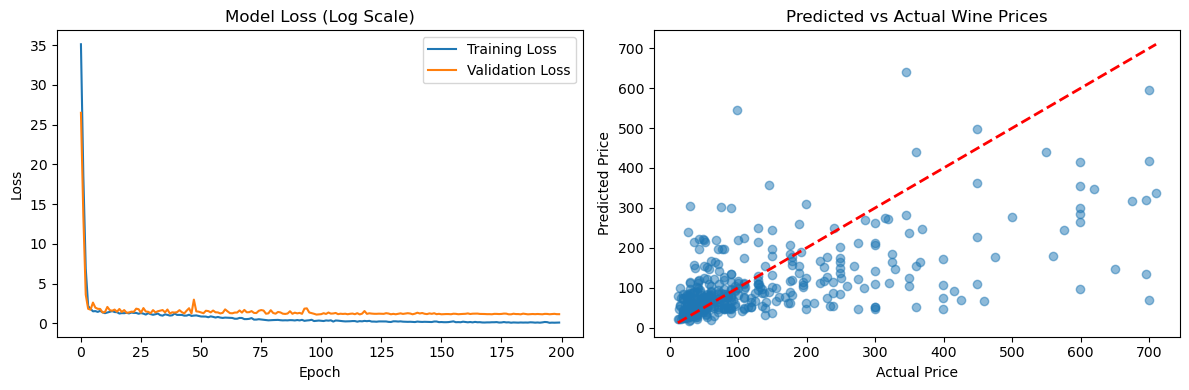


Median Relative Error: 46.8%

Example Predictions:
Actual: $269.00, Predicted: $153.46, Difference: $115.54, Relative Error: 43.0%
Actual: $225.00, Predicted: $115.65, Difference: $109.35, Relative Error: 48.6%
Actual: $179.00, Predicted: $157.11, Difference: $21.89, Relative Error: 12.2%
Actual: $24.99, Predicted: $54.90, Difference: $29.91, Relative Error: 119.7%
Actual: $79.99, Predicted: $127.72, Difference: $47.73, Relative Error: 59.7%

Prediction Accuracy by Price Range:
$0-$50: MAE=$37.38, Median Relative Error=67.5%
$50-$100: MAE=$40.51, Median Relative Error=34.9%
$100-$200: MAE=$59.93, Median Relative Error=37.1%
$200-$500: MAE=$163.99, Median Relative Error=52.4%
$500-$inf: MAE=$342.18, Median Relative Error=52.8%


In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Get predictions
model.eval()
y_pred_log = []
y_true_log = []

with torch.no_grad():
    for batch_embeddings, batch_prices in test_loader:
        batch_embeddings = batch_embeddings.to(device)
        outputs = model(batch_embeddings).cpu().numpy()
        y_pred_log.extend(outputs)
        y_true_log.extend(batch_prices.numpy())

y_pred_log = np.array(y_pred_log).reshape(-1)
y_true_log = np.array(y_true_log)

# Convert predictions back to original scale
y_pred = np.expm1(y_pred_log)  # inverse of log1p
y_true = y_test_orig  # using original prices saved earlier

# Calculate metrics
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

print("Model Performance Metrics:")
print(f"R² Score: {r2:.3f}")
print(f"Mean Absolute Error: ${mae:.2f}")
print(f"Root Mean Squared Error: ${rmse:.2f}")

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss (Log Scale)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Predicted vs Actual Wine Prices')

plt.tight_layout()
plt.show()

# Calculate relative error
relative_error = np.abs(y_true - y_pred) / y_true * 100
print(f"\nMedian Relative Error: {np.median(relative_error):.1f}%")

# Show a few example predictions
print("\nExample Predictions:")
for i in range(5):
    print(f"Actual: ${y_true[i]:.2f}, Predicted: ${y_pred[i]:.2f}, "
          f"Difference: ${abs(y_true[i] - y_pred[i]):.2f}, "
          f"Relative Error: {relative_error[i]:.1f}%")

# Additional analysis of prediction accuracy by price range
price_ranges = [0, 50, 100, 200, 500, float('inf')]
print("\nPrediction Accuracy by Price Range:")
for i in range(len(price_ranges)-1):
    mask = (y_true >= price_ranges[i]) & (y_true < price_ranges[i+1])
    if sum(mask) > 0:
        range_mae = mean_absolute_error(y_true[mask], y_pred[mask])
        range_relative_error = np.median(relative_error[mask])
        print(f"${price_ranges[i]}-${price_ranges[i+1]}: "
              f"MAE=${range_mae:.2f}, Median Relative Error={range_relative_error:.1f}%")

## Improved Results!